# Infraestructure Manager revenue maximization with GSA

## 0. Load libraries

In [63]:
%load_ext autoreload
%autoreload 2

import numpy as np

from benchmarks.railway import Solution, RevenueMaximization
from benchmarks.generator import get_schedule_request, get_revenue_behaviour
from src.entities import GSA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Generate service requests

As an example, we will use the Spanish south high-speed railway corridor.



In [64]:
south_corridor =   {"MAD": {
                        "CIU": {
                            "COR": {
                                "SEV": {
                                    "CAD": {}
                                       },
                                "PGE": {
                                    "ANT": {
                                        "GRA": {},
                                        "MAL": {}
                                            }
                                        }
                                    }
                                }
                            }
                        }

In [65]:
np.random.seed(seed=28)

schedule = get_schedule_request(south_corridor, 100)
revenue = get_revenue_behaviour(schedule)

schedule, revenue

({1: {'CIU': [1302, 1302],
   'COR': [1364, 1369],
   'PGE': [1481, 1487],
   'ANT': [1575, 1580],
   'GRA': [1628, 1628]},
  2: {'MAD': [606, 606],
   'CIU': [679, 685],
   'COR': [797, 800],
   'SEV': [905, 912],
   'CAD': [995, 995]},
  3: {'MAD': [933, 933],
   'CIU': [1033, 1039],
   'COR': [1091, 1098],
   'SEV': [1136, 1140],
   'CAD': [1170, 1170]},
  4: {'MAD': [963, 963],
   'CIU': [1005, 1008],
   'COR': [1115, 1118],
   'PGE': [1203, 1206],
   'ANT': [1234, 1238],
   'GRA': [1281, 1281]},
  5: {'COR': [537, 537],
   'PGE': [614, 620],
   'ANT': [730, 737],
   'MAL': [762, 762]},
  6: {'PGE': [1284, 1284], 'ANT': [1388, 1392], 'MAL': [1490, 1490]},
  7: {'PGE': [980, 980], 'ANT': [1015, 1021], 'GRA': [1086, 1086]},
  8: {'MAD': [976, 976],
   'CIU': [1045, 1051],
   'COR': [1081, 1087],
   'SEV': [1131, 1137],
   'CAD': [1184, 1184]},
  9: {'ANT': [476, 476], 'MAL': [548, 548]},
  10: {'COR': [489, 489],
   'PGE': [559, 566],
   'ANT': [632, 635],
   'GRA': [700, 700]},
  11

In [3]:
np.random.seed(seed=28)

# Dummy schedule
schedule = {1: {'MAD': [0, 0], 'BAR': [148, 152], 'FIG': [180, 180]},
            2: {'MAD': [8, 8], 'ZAR': [28, 30], 'BAR': [165, 167], 'FIG': [210, 210]},
            3: {'MAD': [30, 30], 'BAR': [180, 182], 'FIG': [225, 225]}}

for service in schedule:
    for station in schedule[service]:
        schedule[service][station] = np.array(schedule[service][station], dtype=int)
        
revenue = get_revenue_behaviour(schedule)

schedule, revenue

({1: {'MAD': array([0, 0]),
   'BAR': array([148, 152]),
   'FIG': array([180, 180])},
  2: {'MAD': array([8, 8]),
   'ZAR': array([28, 30]),
   'BAR': array([165, 167]),
   'FIG': array([210, 210])},
  3: {'MAD': array([30, 30]),
   'BAR': array([180, 182]),
   'FIG': array([225, 225])}},
 {1: {'canon': 222.75,
   'k': 1.05,
   'dt_max_penalty': 31.18,
   'tt_max_penalty': 28.96},
  2: {'canon': 242.0,
   'k': 1.03,
   'dt_max_penalty': 33.88,
   'tt_max_penalty': 20.97},
  3: {'canon': 198.0,
   'k': 1.18,
   'dt_max_penalty': 27.72,
   'tt_max_penalty': 25.74}})

In [66]:
sm = RevenueMaximization(schedule, revenue, safe_headway=10)

In [67]:
gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
               is_feasible=sm.feasible_services_times,
               custom_repair=sm.custom_repair,
               r_dim=len(sm.boundaries.real),
               d_dim=0,
               boundaries=sm.boundaries)

In [68]:
import cProfile as profile
import time

pr = profile.Profile()
pr.disable()

gsa_algo.set_seed(seed=28)

pop_size = 20

start = time.time()
pr.enable()
training_history = gsa_algo.optimize(population_size=pop_size,
                                     iters=100,
                                     chaotic_constant=True,
                                     repair_solution=True,
                                     initial_population=sm.get_initial_population(pop_size))
pr.disable()
print(f"Elapsed time: {round(time.time() - start, 2)} seconds")

pr.dump_stats('profile.pstat')

Initial population: [<src.entities.Solution object at 0x17f52ab50>, <src.entities.Solution object at 0x17f98b0d0>, <src.entities.Solution object at 0x17f98b400>, <src.entities.Solution object at 0x17f98b0a0>, <src.entities.Solution object at 0x17f98b6a0>, <src.entities.Solution object at 0x17f98bf70>, <src.entities.Solution object at 0x17f98b520>, <src.entities.Solution object at 0x17f98ba60>, <src.entities.Solution object at 0x17f98b670>, <src.entities.Solution object at 0x17f98b9d0>, <src.entities.Solution object at 0x17f98b460>, <src.entities.Solution object at 0x17f98b550>, <src.entities.Solution object at 0x17f98b730>, <src.entities.Solution object at 0x17f98bc40>, <src.entities.Solution object at 0x17f98b610>, <src.entities.Solution object at 0x17f98bb50>, <src.entities.Solution object at 0x17f98b880>, <src.entities.Solution object at 0x17f98b100>, <src.entities.Solution object at 0x17f98b850>, <src.entities.Solution object at 0x17f98baf0>]
[1306 1375 1493 1587  611  692  807  92

In [38]:
# Get last value in column 'Real' of training_history
best_solution_real = training_history.iloc[-1]['Real']
best_solution_real

array([1302., 1369., 1488., 1581.,  606.,  685.,  800.,  913.,  936.,
       1044., 1104., 1146.,  961., 1008., 1118., 1206., 1240.,  537.,
        620.,  737., 1284., 1393.,  980., 1023.,  976., 1051., 1088.,
       1138.,  476.,  489.,  566.,  635.])

In [39]:
sm.best_solution.real

array([1302., 1369., 1488., 1581.,  606.,  685.,  800.,  913.,  936.,
       1044., 1104., 1146.,  961., 1008., 1118., 1206., 1238.,  537.,
        620.,  737., 1284., 1392.,  980., 1023.,  976., 1051., 1088.,
       1138.,  476.,  489.,  566.,  635.])

In [40]:
best_solution = Solution(real=np.array(best_solution_real), discrete=sm.get_heuristic_schedule(np.array(best_solution_real)))

best_solution.real, best_solution.discrete

(array([1302., 1369., 1488., 1581.,  606.,  685.,  800.,  913.,  936.,
        1044., 1104., 1146.,  961., 1008., 1118., 1206., 1240.,  537.,
         620.,  737., 1284., 1393.,  980., 1023.,  976., 1051., 1088.,
        1138.,  476.,  489.,  566.,  635.]),
 array([ True,  True, False,  True,  True,  True,  True,  True,  True,
         True]))

In [41]:
sm.is_feasible(best_solution, best_solution.discrete)

True

In [42]:
sm.get_fitness_gsa(best_solution_real)

(2502.267089235636, 0)

In [43]:
sm.get_revenue(best_solution)

2502.267089235636

In [44]:
sm.operational_times

{1: [62, 5, 112, 6, 88, 5, 48],
 2: [73, 6, 112, 3, 105, 7, 83],
 3: [100, 6, 52, 7, 38, 4, 30],
 4: [42, 3, 107, 3, 85, 3, 28, 4, 43],
 5: [77, 6, 110, 7, 25],
 6: [104, 4, 98],
 7: [35, 6, 65],
 8: [69, 6, 30, 6, 44, 6, 47],
 9: [72],
 10: [70, 7, 66, 3, 65]}

In [45]:
sm.update_schedule(sm.best_solution)
sm.updated_schedule

{1: {'CIU': [1302.0, 1302.0],
  'COR': [1364.0, 1369.0],
  'PGE': [1481.0, 1488.0],
  'ANT': [1576.0, 1581.0],
  'GRA': [1629.0, 1629.0]},
 2: {'MAD': [606.0, 606.0],
  'CIU': [679.0, 685.0],
  'COR': [797.0, 800.0],
  'SEV': [905.0, 913.0],
  'CAD': [996.0, 996.0]},
 3: {'MAD': [936.0, 936.0],
  'CIU': [1036.0, 1044.0],
  'COR': [1096.0, 1104.0],
  'SEV': [1142.0, 1146.0],
  'CAD': [1176.0, 1176.0]},
 4: {'MAD': [961.0, 961.0],
  'CIU': [1003.0, 1008.0],
  'COR': [1115.0, 1118.0],
  'PGE': [1203.0, 1206.0],
  'ANT': [1234.0, 1238.0],
  'GRA': [1281.0, 1281.0]},
 5: {'COR': [537.0, 537.0],
  'PGE': [614.0, 620.0],
  'ANT': [730.0, 737.0],
  'MAL': [762.0, 762.0]},
 6: {'PGE': [1284.0, 1284.0],
  'ANT': [1388.0, 1392.0],
  'MAL': [1490.0, 1490.0]},
 7: {'PGE': [980.0, 980.0], 'ANT': [1015.0, 1023.0], 'GRA': [1088.0, 1088.0]},
 8: {'MAD': [976.0, 976.0],
  'CIU': [1045.0, 1051.0],
  'COR': [1081.0, 1088.0],
  'SEV': [1132.0, 1138.0],
  'CAD': [1185.0, 1185.0]},
 9: {'ANT': [476.0, 476.0]

In [46]:
sm.get_revenue(sm.best_solution)

2506.1265410987203

In [47]:
sm.is_feasible(sm.best_solution, sm.best_solution.discrete)

True

In [48]:
training_history

,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real
0,0,2236.211492,0,0.012476,[],"[1301, 1371, 1491, 1584, 606, 686, 803, 916, 9..."
1,1,2341.760503,0,0.053748,[],"[1301, 1372, 1492, 1585, 605, 684, 803, 915, 9..."
2,2,2341.760503,0,0.094415,[],"[1302.0, 1371.0, 1489.0, 1587.0, 609.0, 691.0,..."
3,3,2341.760503,0,0.135977,[],"[1302.0, 1371.0, 1489.0, 1587.0, 609.0, 691.0,..."
4,4,2341.760503,0,0.174427,[],"[1302.0, 1371.0, 1489.0, 1587.0, 609.0, 691.0,..."
...,...,...,...,...,...,...
95,95,2506.126541,0,2.835146,[],"[1302.0, 1369.0, 1488.0, 1581.0, 606.0, 685.0,..."
96,96,2506.126541,0,2.854720,[],"[1302.0, 1369.0, 1488.0, 1581.0, 606.0, 685.0,..."
97,97,2506.126541,0,2.874672,[],"[1302.0, 1369.0, 1488.0, 1581.0, 606.0, 685.0,..."
98,98,2506.126541,0,2.893844,[],"[1302.0, 1369.0, 1488.0, 1581.0, 606.0, 685.0,..."


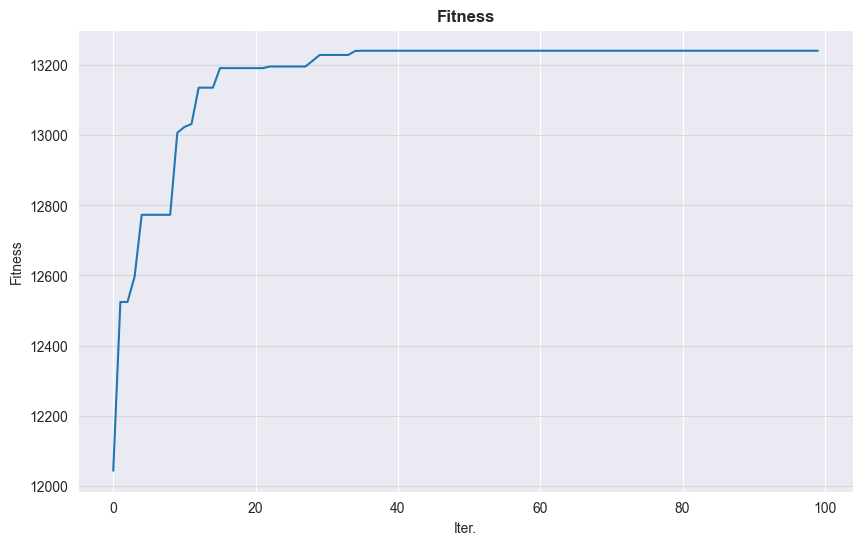

In [62]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=training_history,
             x="Iteration",
             y="Fitness",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [19]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!


In [20]:
sum([revenue[service]['canon'] for service in revenue])

25423.75